In [1]:
file_name = "graph_path_planning.ipynb"
import sys
import os
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname(file_name), '../../src/') ))

import numpy as np
import math
from random import randrange
import matplotlib.pyplot as plt

from utils import *

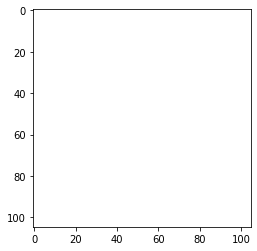

(105, 105) (-2.6, 2.6) (2.5999999999999814, -2.5999999999999814)


In [2]:
lim_x = lim_y = [-2.6, 2.6]
cell_size = 0.05

centers_x = np.arange(lim_x[0], lim_x[1]+cell_size, cell_size)
centers_y = np.arange(lim_y[1], lim_y[0]-cell_size, -cell_size)

num_cells_x = len(centers_x)
num_cells_y = len(centers_y)

grid = []
for i in range(num_cells_x):
    grid.append([])
    for j in range(num_cells_y):
        grid[i].append(0)

grid = np.array(grid)

im = plt.imshow(grid, cmap='Greys')
plt.show()

print(grid.shape, (centers_x[0], centers_y[0]), (centers_x[-1], centers_y[-1]))

In [3]:
def check_angle(ang_l, ang_h, phi):
    if ang_l < ang_h:
        if ang_l <= phi <= ang_h:
            return True
    elif ang_l > ang_h:
        if ang_l <= phi or phi <=ang_h:
            return True
    return False
    
def change_cell(op, cell, value):
    value = abs(value)
    if op == "decrease":
        if cell > -1000:
            return -value
        else:
            return 0
    elif op == "increase":
        if cell < 1000:
            return value
        else:
            return 0
    else:
        return 0

def fill_grid(sensor_pos, sensor_deg, distance):
    
    xs, ys = sensor_pos[0], sensor_pos[1]
    z = distance
    e = 0.2
    theta = sensor_deg[2]
    
    a = 60 * (np.pi/180) # degrees to rad
    
    ring_l = (z - e/2)**2
    ring_h = (z + e/2)**2
    
    ang_l = (theta - a/2)
    ang_h = (theta + a/2)
    
    if ang_l < -np.pi:
        ang_l = ang_l + 2*np.pi
    if ang_h > np.pi:
        ang_h = ang_h - 2*np.pi
    
    cont=0
    
    for y in range(num_cells_y):
        for x in range(num_cells_x):
            
            xg, yg = centers_x[x], centers_y[y]
        
            # check if inside ring
            dist_to_sensor = (xg - xs)**2 + (yg - ys)**2
            phi = np.arctan2((yg - ys),(xg - xs))
            
            
            if 0.01 > z:
                continue
            if z > 2:
                if 0.01 <= dist_to_sensor <=2:
                    if check_angle(ang_l, ang_h, phi):
                        grid[y][x] += change_cell("decrease", grid[y][x], 100)
                continue
            
            
            if dist_to_sensor < 0.01: 
            #too close 
                grid[y][x] += change_cell("decrease", grid[y][x], 100)
            elif dist_to_sensor > 2: 
            #too far
                continue
            elif ring_l <= dist_to_sensor <= ring_h:
            # dentro do setor do anel
                if check_angle(ang_l, ang_h, phi):
                    grid[y][x] += change_cell("increase", grid[y][x], 50)
            elif 0.01 < dist_to_sensor < ring_l:
            # antes do setor do anel
                if check_angle(ang_l, ang_h, phi):
                    grid[y][x] += change_cell("decrease", grid[y][x], 100)
            elif ring_h < dist_to_sensor < 2 :
            # depois do setor do anel
                continue
                
                    
    #print(cont, round(math.degrees(pmn),2), round(math.degrees(pmx),2))

In [4]:
'''
distance = 1
pos_sensor = [0,0]
ang_robo = [0,0, -0 * (np.pi/180)]
print(f'distance = {distance}')
fill_grid(pos_sensor, ang_robo, distance)
im = plt.imshow(grid, cmap='gray')
plt.show()
'''

"\ndistance = 1\npos_sensor = [0,0]\nang_robo = [0,0, -0 * (np.pi/180)]\nprint(f'distance = {distance}')\nfill_grid(pos_sensor, ang_robo, distance)\nim = plt.imshow(grid, cmap='gray')\nplt.show()\n"

In [5]:
clientID = connect_2_sim()
test_connection(clientID)

Connected to remote API server
Number of objects in the scene:  42


In [6]:
# Recuperar handlers do dr20
errorCode, robo = sim.simxGetObjectHandle(clientID=clientID, objectName="./dr20",
                                          operationMode=sim.simx_opmode_blocking)

error_pos, pos_robo = sim.simxGetObjectPosition(clientID, robo, -1, sim.simx_opmode_blocking)
error_ang, ang_robo = sim.simxGetObjectOrientation(clientID, robo, -1, sim.simx_opmode_blocking)

# getting sensor handle
sensor_reference = './dr20/ultrasonicSensorJoint_/ultrasonicSensor_'
err_code, sensor = sim.simxGetObjectHandle(clientID=clientID,
                                            objectName=sensor_reference,
                                            operationMode=sim.simx_opmode_blocking)

error_pos, pos_sensor = sim.simxGetObjectPosition(clientID, sensor, -1, sim.simx_opmode_blocking)
error_ang, ang_sensor = sim.simxGetObjectOrientation(clientID, sensor, -1, sim.simx_opmode_blocking)

In [7]:
from IPython.display import clear_output

while True:
    clear_output(wait=True)
    _, _, detected_point, _, _ = sim.simxReadProximitySensor(clientID=clientID, sensorHandle=sensor, operationMode=sim.simx_opmode_blocking)
    distance = np.sqrt(detected_point[0]**2 + detected_point[1]**2 + detected_point[2]**2)

    error_pos, pos_sensor = sim.simxGetObjectPosition(clientID, sensor, -1, sim.simx_opmode_blocking)
    error_ang, ang_sensor = sim.simxGetObjectOrientation(clientID, sensor, -1, sim.simx_opmode_buffer)
    error_ang, ang_robo = sim.simxGetObjectOrientation(clientID, robo, -1, sim.simx_opmode_blocking)
    
    print(pos_sensor[0], pos_sensor[1], pos_sensor[2])
    print(ang_robo[2])
    
    print(f'distance = {distance}')
    fill_grid(pos_sensor, ang_robo, distance)
    
    im = plt.imshow(grid, cmap='gray', vmin=-1000, vmax=1000)
    plt.show()
    
    time.sleep(0.1)

KeyboardInterrupt: 

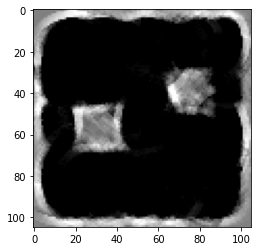

In [10]:
im = plt.imshow(grid, cmap='gray', vmin=-1000, vmax=1000)
plt.show()

In [12]:
grid_arr = np.array(grid)
np.save('grid.npy', grid_arr)